In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df = pd.read_csv('eFarm_Data_2706-1242.csv', parse_dates=['Time'])

In [3]:
print(df.shape)

(51962, 5)


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51962 entries, 0 to 51961
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Time          51962 non-null  datetime64[ns]
 1   SoilMoisture  51962 non-null  float64       
 2   Temperature   51962 non-null  float64       
 3   Humidity      51962 non-null  float64       
 4   Pressure      51962 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.0 MB
None


In [5]:
print(df.describe(include='all'))
date_time_is_numeric = True

                       Time  SoilMoisture   Temperature      Humidity  \
count                 51962  51962.000000  51962.000000  51962.000000   
unique                51947           NaN           NaN           NaN   
top     2022-06-27 09:56:13           NaN           NaN           NaN   
freq                      3           NaN           NaN           NaN   
first   2021-11-20 20:23:20           NaN           NaN           NaN   
last    2022-06-27 12:41:54           NaN           NaN           NaN   
mean                    NaN     75.104480     15.137632     62.920382   
std                     NaN     18.175753      9.597554     16.127551   
min                     NaN      0.000000   -141.290000      0.000000   
25%                     NaN     53.800000      6.420000     49.580000   
50%                     NaN     86.000000     13.240000     63.020000   
75%                     NaN     89.000000     24.130000     77.410000   
max                     NaN    100.000000     57.31

C:\Users\Jovan\AppData\Local\Temp\ipykernel_17972\946578771.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(include='all'))


In [6]:
df.sort_values(by=['Time'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [7]:
df = df.drop(columns=['Time'])

<AxesSubplot:>

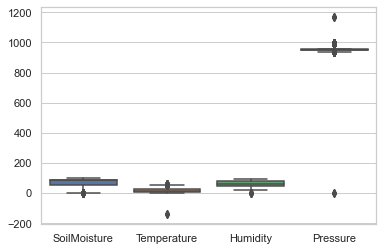

In [8]:
# Handle outliners by drawing box plot and analyze graphics
# On this plot has been seen that Temperature, Humidity and Pressure have incorrect values.

sns.set(rc={'figure.figsize':(20,8)}, style='whitegrid')
sns.boxplot(data=df)

In [9]:
df = df[df['Humidity'] > 0]
df = df[df['Pressure'] > 0]
df.reset_index(inplace=True, drop=True)
print(df.shape)

(51953, 4)


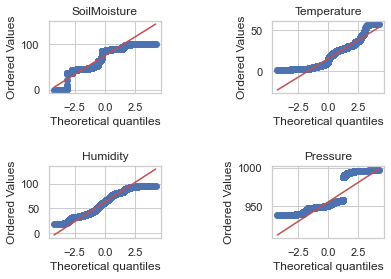

In [10]:
# Drawing Q-Q plot to see graphical comparison between probability distributions

fig, axes = plt.subplots(2,2)
plt.subplots_adjust(hspace = 1, wspace = 1)
for i, column in enumerate(df.columns[0:4]):
    stats.probplot(df[column], dist="norm", plot=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_title(column)
plt.show()

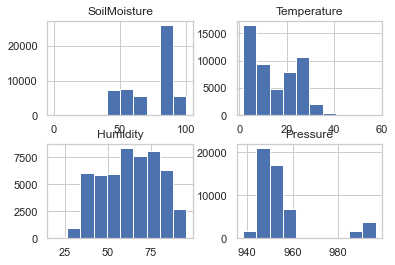

In [11]:
# Drawing histogram to see approximate representation of the distribution of numerical data
# Neither of plots shows that data is left or right skewed, so data transformation will not be done.

fig, axes = plt.subplots(2,2)
plt.subplots_adjust(hspace = 2)
for i, column in enumerate(df.columns[0:4]):
    temp_df = pd.DataFrame(df[column], columns=[column])
    temp_df.hist(ax=axes[int(i/2)][i%2])
plt.show()

In [12]:
# Splitting data as train and test data frames. 20% of data for testing.

df_data = df.drop('Temperature', axis=1)
df_target = pd.DataFrame(df['Temperature'], columns=['Temperature'])
x_train, x_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.2, random_state=42)

In [13]:
# Data scaling/Standardization

std_columns = ['SoilMoisture',
               'Humidity',
               'Pressure']

In [14]:
# for feature data

scaler_train = StandardScaler()
scaler_train.fit(x_train[std_columns])
x_train_scaled = scaler_train.transform(x_train[std_columns])
x_test_scaled = scaler_train.transform(x_test[std_columns])
df_x_train_standardized = pd.DataFrame(x_train_scaled, columns = std_columns)
df_x_test_standardized = pd.DataFrame(x_test_scaled, columns = std_columns)

# for target data

scaler_target = StandardScaler()
scaler_target.fit(y_train)
y_train_scaled = scaler_target.transform(y_train)
y_test_scaled = scaler_target.transform(y_test)
df_y_train_standardized = pd.DataFrame(y_train_scaled, columns = ['Temperature'])
df_y_test_standardized = pd.DataFrame(y_test_scaled, columns = ['Temperature'])

<AxesSubplot:>

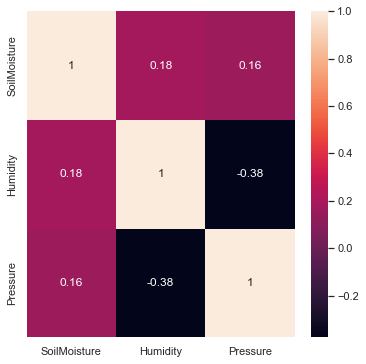

In [15]:
# Drawing correlation matrix of the training data set to identify significant features.

sns.set(rc={'figure.figsize':(6,6)})
sns.heatmap(df_x_train_standardized.corr(), annot=True)

In [16]:
# Fitting training data into Principal Component Analysis (PCA)

pca = PCA()
pca.fit(x_train)
pca.explained_variance_ratio_

array([0.47164876, 0.38558227, 0.14276898])

In [17]:
# All 3 components will be used

pca = PCA(n_components=3)
pca.fit(x_train)
pca_x_train = pca.transform(x_train)
pca_x_test = pca.transform(x_test)

In [18]:
# Model training - Linear model

lm = linear_model.LinearRegression()
model = lm.fit(pca_x_train, y_train)

In [19]:
# Prediction

predictions = lm.predict(pca_x_train)
y_train_pred = pd.DataFrame(predictions, columns=['PredictedTemperature'])

In [20]:
# Training model evaluation - accuracy measurements of the model.

# Mean Squred Error
mse = mean_squared_error(y_train, y_train_pred)
print('Mean squared error(Training) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_train, y_train_pred))
print('Root mean squared error(Training) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_train, y_train)
print('Explained variance of the predictions(Training) :', round(score * 100, 4))

Mean squared error(Training) : 8.8359
Root mean squared error(Training) : 2.9725
Explained variance of the predictions(Training) : 90.2098


In [21]:
# Testing model evaluation - accuracy measurements of the model.

predictions = lm.predict(pca_x_test)
y_pred = pd.DataFrame(predictions, columns=['PredictedTemperature'])
# Mean Squred Error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error(Testing) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_test, y_pred))
print('Root mean squared error(Testing) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_test, y_test)
print('Explained variance of the predictions(Testing) :', round(score * 100, 4))

Mean squared error(Testing) : 9.0306
Root mean squared error(Testing) : 3.0051
Explained variance of the predictions(Testing) : 89.9765


In [22]:
# Get y_test information

print(y_test.info())
print(y_test.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10391 entries, 25386 to 2666
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  10391 non-null  float64
dtypes: float64(1)
memory usage: 162.4 KB
None
        Temperature
count  10391.000000
mean      15.115657
std        9.492245
min        1.720000
25%        6.370000
50%       13.310000
75%       24.130000
max       57.310000


In [23]:
# Get y_pred information

print(y_pred.info())
print(y_pred.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10391 entries, 0 to 10390
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PredictedTemperature  10391 non-null  float64
dtypes: float64(1)
memory usage: 81.3 KB
None
       PredictedTemperature
count          10391.000000
mean              15.158055
std                9.104312
min                0.271339
25%                6.656588
50%               14.557324
75%               22.609669
max               53.101077


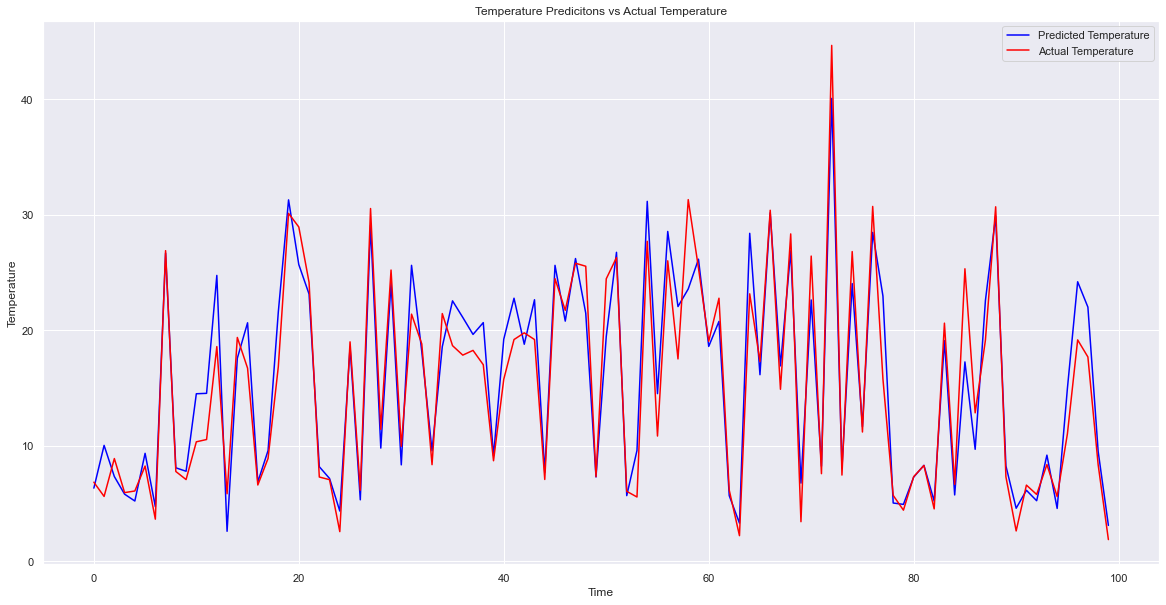

In [24]:
# Draw plot with actual temperature and predicted temperature comparison
# In this example last 100 rows were used
# Number of used rows will be changed during project demonstration

y_test.reset_index(drop=True, inplace=True) # Reset index to align actual and predicted values
sns.set(rc={'figure.figsize':(20,10)})
plt.plot(y_pred[:100], label='Predicted Temperature', color='blue')
plt.plot(y_test[:100], label='Actual Temperature', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Predicitons vs Actual Temperature')
plt.legend()
plt.show()

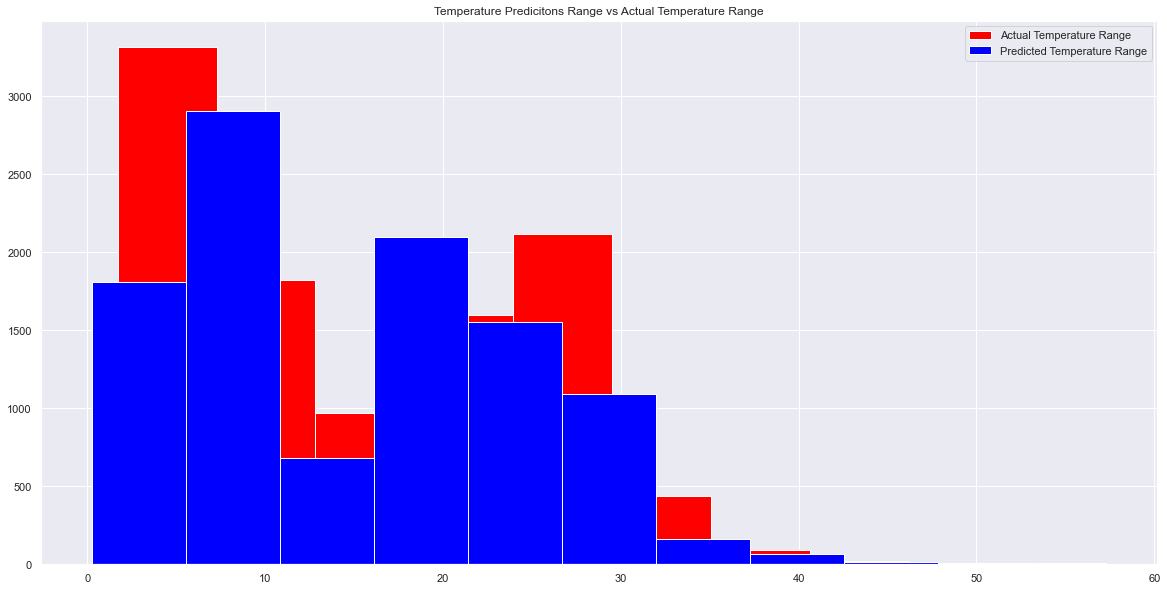

In [25]:
# Draw plot with actual temperature and predicted temperature range comparison

temp_test = pd.DataFrame(y_test['Temperature'], columns=['Temperature'])
temp_pred = pd.DataFrame(y_pred['PredictedTemperature'], columns=['PredictedTemperature'])

plt.hist(temp_test, color='red', label='Actual Temperature Range')
plt.hist(temp_pred, color='blue', label='Predicted Temperature Range')
plt.legend(loc='upper right')
plt.title('Temperature Predicitons Range vs Actual Temperature Range')
plt.show()